How many dataset : 
109882
109882
(20, 24)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 64)            22784     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 105)               6825      
                                                                 
Total params: 66793 (260.91 KB)
Trainable params: 66793 (260.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/6
2061/206

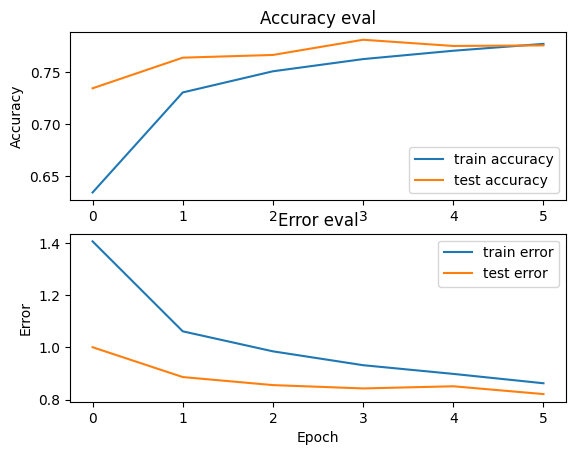

  1/859 [..............................] - ETA: 11s - loss: 1.2036 - accuracy: 0.6875

/opt/anaconda3/envs/yousictube/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


859/859 [==============================] - 3s 3ms/step - loss: 0.8128 - accuracy: 0.7760
Accuracy on test set is: 0.7760183215141296
1/1 [==============================] - 0s 380ms/step
Expected index: 75, Predicted index: [75]


In [5]:
"""

'/**************************************************************************************************************
' 파일명    : train_model_LSTM.py
' 작성자    : 임지백
' 목적      : prepare_dataset.py 파일로 생성한 json 파일에 담긴 코드(chord)별 chromagram 데이터를 토대로 chromagram에 따른 코드를 예측하는 LSTM 모델을 학습시켜 저장
' 사용방식  : 파일의 main문 실행시 LSTM 모델을 새로 학습시켜 저장해준다.
' 사용파일  : chord_classification_service.py에서 chord_classification_service 클래스의 인스턴스 멤버로 이 파일에서 생성한 모델을 갖는다.
' 개발환경  : Python 3.7.7 / Windows10
' 이력사항
'              YYYY. MM/DD 수정자
'               1. 수정 사유: method_name {, method_name}
'/**************************************************************************************************************

"""


import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt


#Chromagram (# time steps, # of coefficient)


JSON_PATH = 'data_twelve_chroma.json'
SAVED_MODEL_PATH = "model_twenty_test.h5"


def load_dataset(data_path):
    """
    ' 목적 : json 파일을 불러와 tensorflow의 인공지능 학습이 가능한 형태로 제공
    ' 리턴값 : 1. chromagram 데이터 (20,24) 배열 2. 코드명 (int로 맵핑된) 배열
    """
    with open(data_path, 'r') as fp:
        data = json.load(fp)

    # extract inputs and targets

    X_array = np.array(data["Chromagram_bundles"])
    y_array = np.array(data["labels"])

    return X_array,y_array


def plot_history(history):
    """
    ' 목적 : 모델 학습 기록을 시각화한 그래프를 띄워준다
    ' 리턴값 : 없음
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()



def prepare_datasets(test_size, validation_size):
    """
    ' 목적 : train set, test set, validation set으로 데이터를 나눠준다
    ' 리턴값 : 1 & 4 : train set / 2 & 5 : validation set / : 3 & 6 test set
    """


    # load data
    X, y = load_dataset(JSON_PATH)
    print("How many dataset : ")
    print(len(X))
    print(len(y))

    # create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # create train/validation split
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):
    """
    ' 목적 : 인공지능 모델의 신경망을 세팅
    ' 리턴값 : 인공지능 모델
    """


    # create RNN model
    model = keras.Sequential()

    # 2 LSTM layers
    model.add(keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True)) # return_sequences : second lstm에서 이 시퀀스를 사용하고 싶기 떄문에 true로 한다.
    # model.add(keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True)) #레이어를 하나 더 추가하는 것은 큰 효용이 없었다.
    model.add(keras.layers.LSTM(64))

    # dense layer
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.45)) # 0.3 -> 0.45 로 변경. 확실히, test accuracy와 training accuracy의 차이가 줄었고, 심지어 대부분의 학습에서 더 높았다.

    # output layer
    model.add(keras.layers.Dense(105, activation='softmax'))

    return model


def predict(model, X, y):
    """
    ' 목적 : 인공지능 모델로 chromagram 입력값에 따른 코드(int로 맵핑된)를 예측
    ' 리턴값 : 없음
    """

    X = X[np.newaxis, ...]

    # prediction = [[0.1, 0.2, ...]] # softmax의 결과물
    prediction = model.predict(X)  # X -> (1, 20, 24)

    # extract index with max value
    predicted_index = np.argmax(prediction, axis=1)  # [4]
    print("Expected index: {}, Predicted index: {}".format(y, predicted_index))


if __name__ == "__main__":

    # create train, validation and test sets
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    input_shape = (X_train.shape[1], X_train.shape[2])  # (20, 24) (number of slices extract Chromagram, Chromagram)

    print(input_shape)
    model = build_model(input_shape)

    # compile model
    optimizer = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=6)

    # plot accuracy/error for training and validation
    plot_history(history) # 이 결과창을 꺼줘야 모델을 저장할수 있음!!!.....

    model.save(SAVED_MODEL_PATH)

    # evaluate model on test set
    test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
    print("Accuracy on test set is: {}".format(test_accuracy))

    # make prediction on a sample
    X = X_test[100]
    y = y_test[100]

    predict(model, X, y)



In [6]:
import tensorflow.keras as keras

MODEL_PATH = 'model_twenty_test.h5'

# Load the pre-trained model
model = keras.models.load_model(MODEL_PATH)

print("Model loaded successfully.")


Model loaded successfully.
